# Dynamic Topic Models 
Este notebook es una adaptación del tutorial "Dynamic Topic Models en el contexto del estallido social en Chile" preparado por Matthieu Vernier para EVIC2019

Alfredo Morales Herrera

# 1. Definición del Dataset y de sus _Slices_

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import requests_html
import pandas as pd
from pandasql import sqldf
import seaborn as sns

La carpeta _datasets_ contiene un archivo CSV llamado 'dataset_eldinamo_13122019.csv'. Corresponde a un dataset de noticias del medio "El Dinamo" entre el 4 de octubre 2019 y el 13 de diciembre 2019.

In [2]:
dataset="dataset_eldinamo_13122019.csv"
df = pd.read_csv(dataset)
df[:5]

,url,date,text
0,https://www.eldinamo.cl/nacional/2019/12/13/mo...,13 de Diciembre de 2019,El ministro de Vivienda Cristián Monckeberg ...
1,https://www.eldinamo.cl/nacional/2019/12/13/go...,13 de Diciembre de 2019,La Moneda informó que Sebastián Piñera decretó...
2,https://www.eldinamo.cl/nacional/2019/12/13/co...,13 de Diciembre de 2019,La Corte de apelaciones de Santiago declaró ad...
3,https://www.eldinamo.cl/nacional/2019/12/13/in...,13 de Diciembre de 2019,Luego que durante esta mañana la Organización ...
4,https://www.eldinamo.cl/nacional/2019/12/13/in...,13 de Diciembre de 2019,Tras varias semanas de espera la misión de ob...


In [3]:
print("Número de documentos: "+str(df.count()[0]))

Número de documentos: 453


Cambiamos el formato de las fechas para poder utilizar la información más facilmente.

In [4]:
#Modificar la columna "date" para que sea reconocida como fecha y no como texto.
df['date']= df['date'].replace(" de Diciembre de ", "/12/",regex=True)
df['date']= df['date'].replace(" de Noviembre de ", "/11/",regex=True)
df['date']= df['date'].replace(" de Octubre de ", "/10/",regex=True) 
df['date'] =pd.to_datetime(df['date'],format="%d/%m/%Y").dt.date

Para definir cómo dividir el dataset en distintos periodos de tiempo, miremos primero cuántos documentos tenemos y cómo se distribuyen en el tiempo:

In [5]:
#Contar el número de documentos por fecha
query="""SELECT date as fecha,count(*) as documentos
FROM df GROUP BY date;"""
result=sqldf(query)
result

,fecha,documentos
0,2019-10-04,2
1,2019-10-05,3
2,2019-10-06,3
3,2019-10-07,8
4,2019-10-08,5
...,...,...
66,2019-12-09,6
67,2019-12-10,6
68,2019-12-11,8
69,2019-12-12,7


En este ejemplo, divideremos los datos en cinco segmentos de dos semanas:

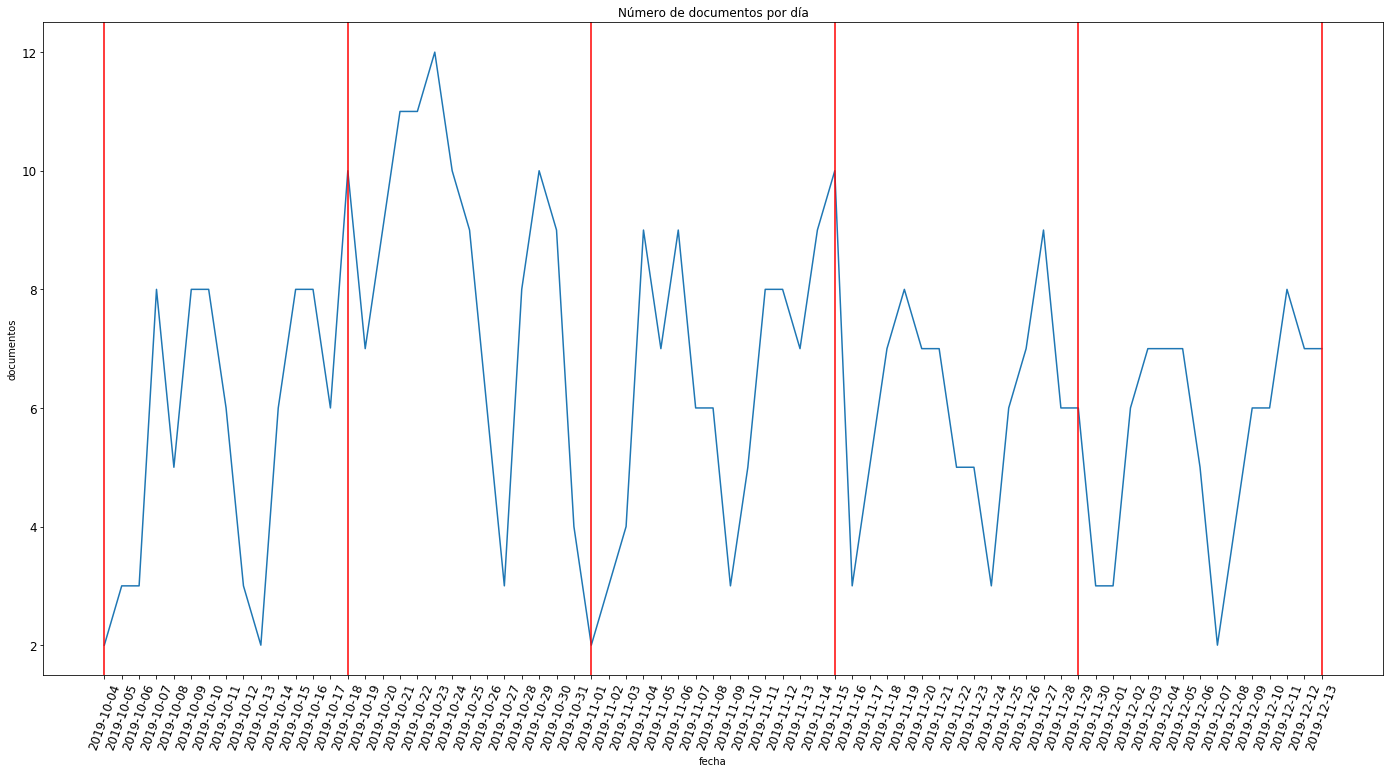

In [6]:
# libraries
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
plt.rcParams['figure.figsize'] = [24, 12]

time_plot = sns.lineplot(x='fecha',
                         y='documentos',
                         data=result
                         ).set_title('Número de documentos por día')
plt.xticks(rotation=70)
plt.tick_params(labelsize=12)

plt.axvline(x='2019-10-04',color='red')
plt.axvline(x='2019-10-18',color='red')
plt.axvline(x='2019-11-01',color='red')
plt.axvline(x='2019-11-15',color='red')
plt.axvline(x='2019-11-29',color='red')
plt.axvline(x='2019-12-13',color='red')

plt.show()

In [7]:
q="""SELECT 'Week 1',count(*) as 'Number of documents'
FROM df WHERE date BETWEEN "2019-10-04" AND "2019-10-17"
UNION
SELECT 'Week 2',count(*) as 'Number of documents'
FROM df WHERE date BETWEEN "2019-10-18" AND "2019-10-31"
UNION
SELECT 'Week 3',count(*) as 'Number of documents'
FROM df WHERE date BETWEEN "2019-11-01" AND "2019-11-15"
UNION
SELECT 'Week 4',count(*) as 'Number of documents'
FROM df WHERE date BETWEEN "2019-11-16" AND "2019-11-29"
UNION
SELECT 'Week 5',count(*) as 'Number of documents'
FROM df WHERE date BETWEEN "2019-11-30" AND "2019-12-13"
;"""
result=sqldf(q)
result

,'Week 1',Number of documents
0,Week 1,76
1,Week 2,119
2,Week 3,96
3,Week 4,84
4,Week 5,78


Para identificar los _slices_, conservamos el número de documentos por cada segmento:

In [8]:
index_slices=[76,119,96,84,78]

# 2. Preprocesamientos: filtrar palabras según categoría gramatical y/o extraer palabras claves

In [9]:
import spacy
nlp = spacy.load('es_core_news_md', disable=['parser','ner','textcat','...'] )

In [10]:
def getNouns(dataFrame,columnName):
    
    for index,rows in dataFrame.iterrows():
        
        text=rows[columnName]
        
        filteredText=""
        
        tokens = nlp(text)
        
        for token in tokens:
            if token.pos_ == "NOUN" :
                filteredText=filteredText+" "+str(token.text.lower().strip())
                
        dataFrame.loc[index,'nouns']=filteredText

In [11]:
%%time
getNouns(df,"text")

CPU times: user 20.2 s, sys: 19.7 ms, total: 20.2 s
Wall time: 20.3 s


In [12]:
#Código from: https://towardsdatascience.com/textrank-for-keyword-extraction-by-python-c0bae21bcec0

from collections import OrderedDict
import numpy as np

from spacy.lang.es.stop_words import STOP_WORDS

nlp.add_pipe(nlp.create_pipe('sentencizer'))

class TextRank4Keyword():
    """Extract keywords from text"""
    
    def __init__(self):
        self.d = 0.85 # damping coefficient, usually is .85
        self.min_diff = 1e-5 # convergence threshold
        self.steps = 10 # iteration steps
        self.node_weight = None # save keywords and its weight

    
    def set_stopwords(self, stopwords):  
        """Set stop words"""
        for word in STOP_WORDS.union(set(stopwords)):
            lexeme = nlp.vocab[word]
            lexeme.is_stop = True
    
    def sentence_segment(self, doc, candidate_pos, lower):
        """Store those words only in cadidate_pos"""
        sentences = []
        for sent in doc.sents:
            selected_words = []
            for token in sent:
                # Store words only with cadidate POS tag
                if token.pos_ in candidate_pos and token.is_stop is False:
                    if lower is True:
                        selected_words.append(token.text.lower())
                    else:
                        selected_words.append(token.text)
            sentences.append(selected_words)
        return sentences
        
    def get_vocab(self, sentences):
        """Get all tokens"""
        vocab = OrderedDict()
        i = 0
        for sentence in sentences:
            for word in sentence:
                if word not in vocab:
                    vocab[word] = i
                    i += 1
        return vocab
    
    def get_token_pairs(self, window_size, sentences):
        """Build token_pairs from windows in sentences"""
        token_pairs = list()
        for sentence in sentences:
            for i, word in enumerate(sentence):
                for j in range(i+1, i+window_size):
                    if j >= len(sentence):
                        break
                    pair = (word, sentence[j])
                    if pair not in token_pairs:
                        token_pairs.append(pair)
        return token_pairs
        
    def symmetrize(self, a):
        return a + a.T - np.diag(a.diagonal())
    
    def get_matrix(self, vocab, token_pairs):
        """Get normalized matrix"""
        # Build matrix
        vocab_size = len(vocab)
        g = np.zeros((vocab_size, vocab_size), dtype='float')
        for word1, word2 in token_pairs:
            i, j = vocab[word1], vocab[word2]
            g[i][j] = 1
            
        # Get Symmeric matrix
        g = self.symmetrize(g)
        
        # Normalize matrix by column
        norm = np.sum(g, axis=0)
        g_norm = np.divide(g, norm, where=norm!=0) # this is ignore the 0 element in norm
        
        return g_norm

    
    def get_keywords(self, number=10):
        """Print top number keywords"""
        l_keywords = []
        node_weight = OrderedDict(sorted(self.node_weight.items(), key=lambda t: t[1], reverse=True))
        for i, (key, value) in enumerate(node_weight.items()):
            #print(key + ' - ' + str(value))
            l_keywords.append( (key, value) )
            if i > number:
                break
        return l_keywords
        
        
    def analyze(self, text, 
                candidate_pos=['NOUN', 'PROPN'], 
                window_size=4, lower=False, stopwords=list()):
        """Main function to analyze text"""
        
        # Set stop words
        self.set_stopwords(stopwords)
        
        # Pare text by spaCy
        doc = nlp(text) #, disable=['parser'])
        
        # Filter sentences
        sentences = self.sentence_segment(doc, candidate_pos, lower) # list of list of words
        
        # Build vocabulary
        vocab = self.get_vocab(sentences)
        
        # Get token_pairs from windows
        token_pairs = self.get_token_pairs(window_size, sentences)
        
        # Get normalized matrix
        g = self.get_matrix(vocab, token_pairs)
        
        # Initionlization for weight(pagerank value)
        pr = np.array([1] * len(vocab))
        
        # Iteration
        previous_pr = 0
        for epoch in range(self.steps):
            pr = (1-self.d) + self.d * np.dot(g, pr)
            if abs(previous_pr - sum(pr))  < self.min_diff:
                break
            else:
                previous_pr = sum(pr)

        # Get weight for each node
        node_weight = dict()
        for word, index in vocab.items():
            node_weight[word] = pr[index]
        
        self.node_weight = node_weight

In [13]:
def getKeywords(dataFrame,columnName):
    
    for index,rows in dataFrame.iterrows():
        
        text=rows[columnName]
        
        keywords=""
        
        tr4w = TextRank4Keyword()
        tr4w.analyze(text, candidate_pos = ['NOUN'], window_size=4, lower=False)
    
        tokens = tr4w.get_keywords(20)

        for token in tokens:

            keywords=keywords+" "+str(token[0])
                
        dataFrame.loc[index,'keywords']=keywords

In [14]:
%%time
getKeywords(df,"text")

CPU times: user 21.9 s, sys: 6 s, total: 27.9 s
Wall time: 21.4 s


In [15]:
df[:5]

,url,date,text,nouns,keywords
0,https://www.eldinamo.cl/nacional/2019/12/13/mo...,2019-12-13,El ministro de Vivienda Cristián Monckeberg ...,ministro investigación cabo caso corrupción i...,funcionarios delitos hechos corrupción person...
1,https://www.eldinamo.cl/nacional/2019/12/13/go...,2019-12-13,La Moneda informó que Sebastián Piñera decretó...,días accidente saldo víctimas mensaje apoyo s...,víctimas sedes pasajeros familiares cuerpos t...
2,https://www.eldinamo.cl/nacional/2019/12/13/co...,2019-12-13,La Corte de apelaciones de Santiago declaró ad...,apelaciones querella intendente dirigente inc...,libertad dirigente resolución expresión derec...
3,https://www.eldinamo.cl/nacional/2019/12/13/in...,2019-12-13,Luego que durante esta mañana la Organización ...,mañana informe situación estallido reacciones...,informe violencia violaciones reparación ofic...
4,https://www.eldinamo.cl/nacional/2019/12/13/in...,2019-12-13,Tras varias semanas de espera la misión de ob...,semanas espera misión observadores informe es...,informe personas derechos forma manifestacion...


# 4. Representación vectorial de los documentos

Utilizaremos la columna "keywords" como simplificación de los documentos.

In [16]:
from gensim.models import TfidfModel
from gensim.corpora import Dictionary

documents=list(df['keywords'])
documents=[x.split(" ") for x in documents]

dictionary = Dictionary(documents)

#dictionary.filter_extremes(no_below=0,no_above=0.99)

dictionary.filter_n_most_frequent(1)

corpus = [dictionary.doc2bow(doc) for doc in documents] 

model = TfidfModel(corpus)

vectorizedCorpus = model[corpus]

## 3. Optimización de modelos de tópicos dinámicos

Entrenamos modelos con k_topics entre 3 y 10, y guardamos los modelos en archivos.

In [18]:
from gensim.models import TfidfModel
from gensim.corpora import Dictionary, bleicorpus
from gensim.models import ldaseqmodel
from gensim.models import LdaSeqModel
from gensim.matutils import hellinger
from gensim.models.coherencemodel import CoherenceModel
from gensim.test.utils import common_corpus
from gensim.test.utils import datapath

import time

In [19]:
%%time

k_topics=[3,4,5,6,7,8,9,10]
DTM_models = []
init=time.time()
for k in k_topics:
    
    s=time.time()
    ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=index_slices, 
                                 num_topics=k,
                                 chain_variance=0.1,
                                 alphas=0.9,
                                 passes=60,
                                 chunksize=50,
                                 em_min_iter=6,
                                 em_max_iter=20)

    DTM_models.append(ldaseq)

    e=time.time()
    print(str(k)+" Topics - Tiempo necesario para la optimización del modelo:",(e-s))
    
    #se guarda el modelo
    path_of_model = datapath("/run/media/amorales/392cf315-7e84-4743-a143-b375a0604f7d/amorales/UACh/magister/INFO343/Unidad4/INFO343/Unidad4/models/model_"+str(k)+"_clase")
    print(path_of_model)
    ldaseq.save(path_of_model)
end=time.time()
print("En total se demoró ",end-init, " segundos")

/home/amorales/anaconda3/envs/IA/lib/python3.7/site-packages/gensim/models/ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


3 Topics - Tiempo necesario para la optimización del modelo: 215.6139476299286
/run/media/amorales/392cf315-7e84-4743-a143-b375a0604f7d/amorales/UACh/magister/INFO343/Unidad4/INFO343/Unidad4/models/model_3_clase


/home/amorales/anaconda3/envs/IA/lib/python3.7/site-packages/gensim/models/ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


4 Topics - Tiempo necesario para la optimización del modelo: 242.42935848236084
/run/media/amorales/392cf315-7e84-4743-a143-b375a0604f7d/amorales/UACh/magister/INFO343/Unidad4/INFO343/Unidad4/models/model_4_clase


/home/amorales/anaconda3/envs/IA/lib/python3.7/site-packages/gensim/models/ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


5 Topics - Tiempo necesario para la optimización del modelo: 278.9454870223999
/run/media/amorales/392cf315-7e84-4743-a143-b375a0604f7d/amorales/UACh/magister/INFO343/Unidad4/INFO343/Unidad4/models/model_5_clase


/home/amorales/anaconda3/envs/IA/lib/python3.7/site-packages/gensim/models/ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


6 Topics - Tiempo necesario para la optimización del modelo: 292.77091574668884
/run/media/amorales/392cf315-7e84-4743-a143-b375a0604f7d/amorales/UACh/magister/INFO343/Unidad4/INFO343/Unidad4/models/model_6_clase


/home/amorales/anaconda3/envs/IA/lib/python3.7/site-packages/gensim/models/ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


7 Topics - Tiempo necesario para la optimización del modelo: 335.21571230888367
/run/media/amorales/392cf315-7e84-4743-a143-b375a0604f7d/amorales/UACh/magister/INFO343/Unidad4/INFO343/Unidad4/models/model_7_clase


/home/amorales/anaconda3/envs/IA/lib/python3.7/site-packages/gensim/models/ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


8 Topics - Tiempo necesario para la optimización del modelo: 365.8745930194855
/run/media/amorales/392cf315-7e84-4743-a143-b375a0604f7d/amorales/UACh/magister/INFO343/Unidad4/INFO343/Unidad4/models/model_8_clase


/home/amorales/anaconda3/envs/IA/lib/python3.7/site-packages/gensim/models/ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


9 Topics - Tiempo necesario para la optimización del modelo: 407.3503339290619
/run/media/amorales/392cf315-7e84-4743-a143-b375a0604f7d/amorales/UACh/magister/INFO343/Unidad4/INFO343/Unidad4/models/model_9_clase


/home/amorales/anaconda3/envs/IA/lib/python3.7/site-packages/gensim/models/ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


10 Topics - Tiempo necesario para la optimización del modelo: 435.8754737377167
/run/media/amorales/392cf315-7e84-4743-a143-b375a0604f7d/amorales/UACh/magister/INFO343/Unidad4/INFO343/Unidad4/models/model_10_clase
En total se demoró  2574.2843339443207  segundos
CPU times: user 42min 28s, sys: 14.2 s, total: 42min 42s
Wall time: 42min 54s


**Ejercicio 1:**
Investigue el rol de los parámetros de entrada de la clase LdaSeqModel, sus valores por omisión y cuales son los criterios para modificar dichos valores.


> los parámetros por defecto de `LdaSeqModel` son:

`ldaseqmodel.LdaSeqModel(
    corpus=None,
    time_slice=None,
    id2word=None,
    alphas=0.01,
    num_topics=10,
    initialize='gensim',
    sstats=None,
    lda_model=None,
    obs_variance=0.5,
    chain_variance=0.005,
    passes=10,
    random_state=None,
    lda_inference_max_iter=25,
    em_min_iter=6,
    em_max_iter=20,
    chunksize=100,
)`

**corpus** : {iterable of list of (int, float), scipy.sparse.csc}, optional
    Stream of document vectors or sparse matrix of shape (`num_documents`, `num_terms`).
    If not given, the model is left untrained (presumably because you want to call
    :meth:`~gensim.models.ldamodel.LdaSeqModel.update` manually).
    
**time_slice** : list of int, optional
    Number of documents in each time-slice. Each time slice could for example represent a year's published
    papers, in case the corpus comes from a journal publishing over multiple years.
    It is assumed that `sum(time_slice) == num_documents`.
    
**id2word** : dict of (int, str), optional
    Mapping from word IDs to words. It is used to determine the vocabulary size, as well as for
    debugging and topic printing.
    
**alphas** : float, optional
    The prior probability for the model.
    
**num_topics** : int, optional
    The number of requested latent topics to be extracted from the training corpus.
    
**initialize** : {'gensim', 'own', 'ldamodel'}, optional
    Controls the initialization of the DTM model. Supports three different modes:
        * 'gensim': Uses gensim's LDA initialization.
        * 'own': Uses your own initialization matrix of an LDA model that has been previously trained.
        * 'lda_model': Use a previously used LDA model, passing it through the `lda_model` argument.
        
**sstats** : numpy.ndarray , optional
    Sufficient statistics used for initializing the model if `initialize == 'own'`. Corresponds to matrix
    beta in the linked paper for time slice 0, expected shape (`self.vocab_len`, `num_topics`).
    
**lda_model** : :class:`~gensim.models.ldamodel.LdaModel`
    Model whose sufficient statistics will be used to initialize the current object if `initialize == 'gensim'`.
    
**obs_variance** : float, optional
    Observed variance used to approximate the true and forward variance as shown in
    `David M. Blei, John D. Lafferty: "Dynamic Topic Models"
    <https://mimno.infosci.cornell.edu/info6150/readings/dynamic_topic_models.pdf>`.
    
**chain_variance** : float, optional
    Gaussian parameter defined in the beta distribution to dictate how the beta values evolve over time.
    
**passes** : int, optional
    Number of passes over the corpus for the initial :class:`~gensim.models.ldamodel.LdaModel`
    
**random_state** : {numpy.random.RandomState, int}, optional
    Can be a np.random.RandomState object, or the seed to generate one. Used for reproducibility of results.
    
**lda_inference_max_iter** : int, optional
    Maximum number of iterations in the inference step of the LDA training.
    
**em_min_iter** : int, optional
    Minimum number of iterations until converge of the Expectation-Maximization algorithm.
    
**em_max_iter** : int, optional
    Maximum number of iterations until converge of the Expectation-Maximization algorithm.
    
**chunksize** : int, optional
    Number of documents in the corpus do be processed in in a chunk.

# 4. Evaluación de los modelos

In [20]:

cv=list()
umass =list()
cuci = list()
cnpmi = list()

for k in k_topics:
    path_of_model = datapath("/run/media/amorales/392cf315-7e84-4743-a143-b375a0604f7d/amorales/UACh/magister/INFO343/Unidad4/INFO343/Unidad4/models/model_"+str(k)+"_clase")
    ldaseq = LdaSeqModel.load(path_of_model)
    
    values_cv=list()
    values_umass = list()
    values_cuci = list()
    values_cnpmi = list()
    
    for time_fragment in range(len(index_slices)):
        topics_wrapper = ldaseq.dtm_coherence(time=time_fragment)
        cm_wrapper_cv = CoherenceModel(topics=topics_wrapper, texts=documents, dictionary=dictionary, coherence='c_v')
        cm_wrapper_umass = CoherenceModel(topics=topics_wrapper, texts=documents, dictionary=dictionary, coherence='u_mass')
        cm_wrapper_cuci = CoherenceModel(topics=topics_wrapper, texts=documents, dictionary=dictionary, coherence='c_uci')
        cm_wrapper_cnpmi = CoherenceModel(topics=topics_wrapper, texts=documents, dictionary=dictionary, coherence='c_npmi')
        values_cv.append(cm_wrapper_cv.get_coherence())
        values_umass.append(cm_wrapper_umass.get_coherence())
        values_cuci.append(cm_wrapper_cuci.get_coherence())
        values_cnpmi.append(cm_wrapper_cnpmi.get_coherence())
    
    average_cv = sum(values_cv) / len(values_cv) 
    average_umass= sum(values_umass) / len(values_umass)
    average_cuci = sum(values_cuci) / len(values_cuci)
    average_cnpmi = sum(values_cnpmi) / len(values_cnpmi)
    cv.append(average_cv)
    umass.append(average_umass)
    cuci.append(average_cuci)
    cnpmi.append(average_cnpmi)

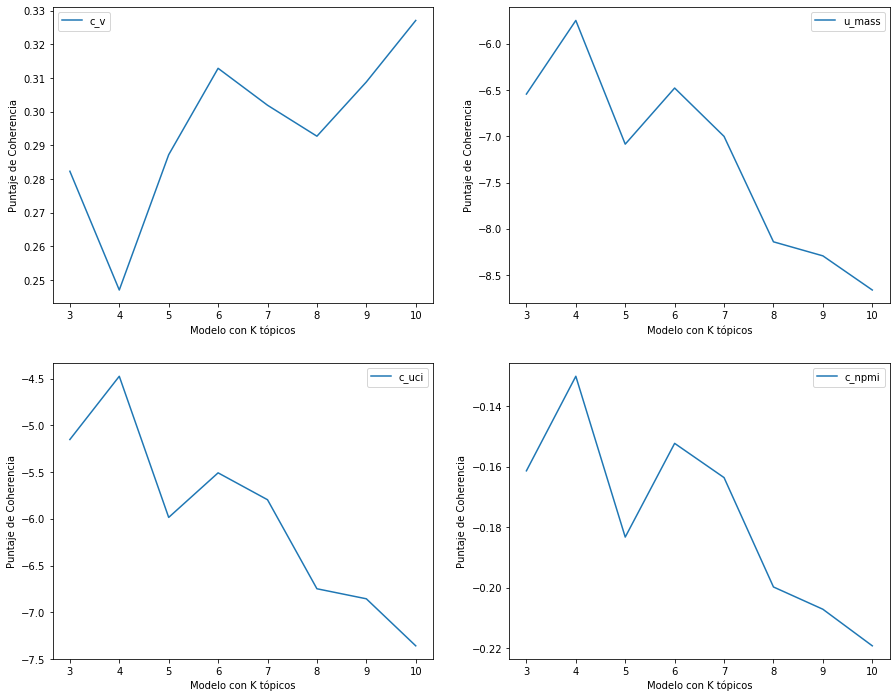

In [21]:
fig, ax = plt.subplots(2,2,figsize=(15,12))
coher_names=['c_v','u_mass','c_uci','c_npmi']
coher_data=[cv,umass,cuci,cnpmi]
k=0
for i in [0,1]:
    for j in [0,1]:
        ax[i,j].plot(k_topics, coher_data[k], label=coher_names[k])
        ax[i,j].set_xlabel('Modelo con K tópicos')
        ax[i,j].set_ylabel('Puntaje de Coherencia')
        ax[i,j].legend()
        k+=1
plt.show()


> Notamos que existe una clara señal en tres de cuatro medidas que las noticias contienen 4 tópicos. Por tanto, cargamos el modelo con 4 tópicos para el análisis de evolución de discurso.

> El siguiente valore más alto y con el que se comparará para el ejercicio 2, es $k=6$ tópicos.

In [24]:
true_k = 4
path_of_model = datapath("/run/media/amorales/392cf315-7e84-4743-a143-b375a0604f7d/amorales/UACh/magister/INFO343/Unidad4/INFO343/Unidad4/models/model_"+str(true_k)+"_clase")
ldaseq = LdaSeqModel.load(path_of_model)

# 5. Análisis de la evolución del discurso

In [25]:
table=[]
for topic in range(true_k):
    for i in range(len(index_slices)):
        row=["topic "+str(topic)]
        row.append("slice "+str(i))
        keywords=ldaseq.print_topic(topic=topic,time=i,top_terms=35)
        for keyword in keywords:
            row.append(str(keyword[0])+", "+str(round(keyword[1],4)))
        table.append(row)

In [26]:
topics_df = pd.DataFrame(table)
topics_df[:]

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,topic 0,slice 0,"hechos, 0.0214","personas, 0.0181","violencia, 0.0147","caso, 0.0141","delitos, 0.0111","violaciones, 0.0107","país, 0.0107","ministro, 0.0101",...,"acción, 0.0053","acciones, 0.0053","armas, 0.0052","abusos, 0.0052","perdigones, 0.0051","fiscal, 0.0051","acusación, 0.0049","delito, 0.0049","manifestaciones, 0.0048","denuncias, 0.0048"
1,topic 0,slice 1,"personas, 0.0196","hechos, 0.0179","violencia, 0.0164","caso, 0.0125","país, 0.0103","años, 0.0095","orden, 0.0095","delitos, 0.0095",...,"derechos, 0.0055","antecedentes, 0.0054","protestas, 0.0054","abusos, 0.0054","fiscal, 0.0053","delito, 0.0049","defensa, 0.0049","abogado, 0.0048","estallido, 0.0048","medidas, 0.0047"
2,topic 0,slice 2,"personas, 0.0205","hechos, 0.0187","violencia, 0.0146","caso, 0.0116","delitos, 0.0103","país, 0.01","ministro, 0.0094","años, 0.0092",...,"protestas, 0.0057","autoridad, 0.0056","antecedentes, 0.0055","denuncias, 0.0052","información, 0.0052","abusos, 0.0052","acciones, 0.0052","organismo, 0.0051","número, 0.0051","informe, 0.005"
3,topic 0,slice 3,"personas, 0.0258","hechos, 0.0195","violencia, 0.0125","caso, 0.0115","delitos, 0.0111","años, 0.0102","situación, 0.0093","ministro, 0.0092",...,"diputado, 0.0056","denuncias, 0.0055","organismo, 0.0053","tipo, 0.0052","policía, 0.0052","acción, 0.0052","marco, 0.0052","abogado, 0.005","información, 0.005","acciones, 0.0048"
4,topic 0,slice 4,"personas, 0.0202","hechos, 0.0168","delitos, 0.0133","caso, 0.0123","años, 0.0111","violencia, 0.0105","justicia, 0.0097","situación, 0.0095",...,"diputado, 0.0054","violaciones, 0.0054","número, 0.0053","saqueos, 0.0052","denuncias, 0.005","defensa, 0.005","organismo, 0.005","información, 0.005","marco, 0.0049","responsables, 0.0048"
5,topic 1,slice 0,"responsabilidad, 0.014","manifestaciones, 0.0097","institución, 0.0076","acusación, 0.0076","año, 0.0068","personas, 0.0063","servicios, 0.0061","manifestantes, 0.0061",...,"alza, 0.0044","ley, 0.0044","rechazo, 0.0043","libelo, 0.0041","fuerza, 0.0041","balines, 0.0039","mes, 0.0038","gabinete, 0.0037","objetivo, 0.0037","infraestructura, 0.0037"
6,topic 1,slice 1,"responsabilidad, 0.0118","manifestaciones, 0.0105","institución, 0.0073","personas, 0.0068","año, 0.0063","manifestantes, 0.0057","acusación, 0.0057","servicios, 0.0055",...,"rechazo, 0.0042","apoyo, 0.0042","estaciones, 0.004","balines, 0.004","fuerza, 0.004","gabinete, 0.0039","mandatario, 0.0038","demandas, 0.0037","diputado, 0.0037","protestas, 0.0036"
7,topic 1,slice 2,"manifestaciones, 0.011","responsabilidad, 0.0086","alza, 0.0074","personas, 0.0074","calles, 0.0061","militares, 0.0061","institución, 0.0059","año, 0.0056",...,"agua, 0.0043","grupo, 0.0043","protestas, 0.0043","partido, 0.0042","capital, 0.0042","documento, 0.0041","domingo, 0.0039","rechazo, 0.0039","apoyo, 0.0038","diputado, 0.0038"
8,topic 1,slice 3,"alza, 0.0114","manifestaciones, 0.0103","personas, 0.0086","calles, 0.0076","responsabilidad, 0.0072","militares, 0.007","estaciones, 0.0069","mañana, 0.0064",...,"servicios, 0.0044","pasaje, 0.0043","tarifa, 0.0041","domingo, 0.0039","documento, 0.0039","partido, 0.0038","suspensión, 0.0038","grupo, 0.0038","comunas, 0.0038","emergencia, 0.0038"
9,topic 1,slice 4,"alza, 0.0093","manifestaciones, 0.008","personas, 0.0078","responsabilidad, 0.0074","mañana, 0.0073","calles, 0.0068","estaciones, 0.0064","año, 0.0059",...,"pasaje, 0.0042","institución, 0.0042","pesos, 0.004","chilenos, 0.004","fuerza, 0.004","partido, 0.0039","gabinete, 0.0039","vida, 0.0038","documento, 0.0038","comunas, 0.0038"


Creamos una lista con palabras que no aportan mayor significado semántico a los tópicos.

In [71]:
useless = ['joven','personal','país','$','hechos','mañana','caso','forma','comuna','años','familia','jornada','lunes','martes','miércoles','jueves','viernes','sábado','domingo']

In [59]:
top_keywords = list()
for topic in range(true_k):
    print("\n#######################################")
    print("Topic = ", topic)
    kws_by_topic = list()
    keywords = []
    for i in range(5):
        col = 2
        values = []
        kw = table[topic*5+i][col].split(', ')[0]
        while((kw in useless) or (kw in keywords)):
            col+=1
            kw = table[topic*5+i][col].split(', ')[0]
        keywords.append(kw)
        print("\n····················")
        print("kw[",i,"] = ", kw)
        for slc in range(5):
            # el valor de la palabra encontrada en cada slice
            print("\n-------------------------------------")
            print("Slice = ", slc)
            col=2
            kw_ = table[topic*5+slc][col].split(', ')[0]
            while((kw_ != kw) and col<36):
                print(kw_,"no calza con", kw, "  col =",col)
                col+=1
                kw_ = table[topic*5+slc][col].split(', ')[0]
            if col<36:
                sc = float(table[topic*5+slc][col].split(', ')[1])
                print("\n", kw_,"si calza con",kw,)
            else:
                print("palabra",kw,"no encontrada en slice",slc)
                sc = 0
            values.append(sc)
            print("Valores = ",values,"\n")
            
        kws_by_topic.append([kw,values])
    
    top_keywords.append([topic,kws_by_topic])


#######################################
Topic =  0

····················
kw[ 0 ] =  personas

-------------------------------------
Slice =  0
hechos no calza con personas   col = 2

 personas si calza con personas
Valores =  [0.0181] 


-------------------------------------
Slice =  1

 personas si calza con personas
Valores =  [0.0181, 0.0196] 


-------------------------------------
Slice =  2

 personas si calza con personas
Valores =  [0.0181, 0.0196, 0.0205] 


-------------------------------------
Slice =  3

 personas si calza con personas
Valores =  [0.0181, 0.0196, 0.0205, 0.0258] 


-------------------------------------
Slice =  4

 personas si calza con personas
Valores =  [0.0181, 0.0196, 0.0205, 0.0258, 0.0202] 


····················
kw[ 1 ] =  violencia

-------------------------------------
Slice =  0
hechos no calza con violencia   col = 2
personas no calza con violencia   col = 3

 violencia si calza con violencia
Valores =  [0.0147] 


-----------------------------

joven no calza con redes   col = 5
años no calza con redes   col = 6
martes no calza con redes   col = 7
interior no calza con redes   col = 8
delito no calza con redes   col = 9
viernes no calza con redes   col = 10
manifestaciones no calza con redes   col = 11
sector no calza con redes   col = 12
muerte no calza con redes   col = 13
forma no calza con redes   col = 14
familiares no calza con redes   col = 15
víctima no calza con redes   col = 16

 redes si calza con redes
Valores =  [0.0062] 


-------------------------------------
Slice =  1
comuna no calza con redes   col = 2
personas no calza con redes   col = 3
joven no calza con redes   col = 4
años no calza con redes   col = 5
información no calza con redes   col = 6
manifestaciones no calza con redes   col = 7
interior no calza con redes   col = 8
martes no calza con redes   col = 9
forma no calza con redes   col = 10
víctima no calza con redes   col = 11
personal no calza con redes   col = 12
delito no calza con redes   col =

In [60]:
top_keywords

[[0,
  [['personas', [0.0181, 0.0196, 0.0205, 0.0258, 0.0202]],
   ['violencia', [0.0147, 0.0164, 0.0146, 0.0125, 0.0105]],
   ['delitos', [0.0111, 0.0095, 0.0103, 0.0111, 0.0133]],
   ['situación', [0.0071, 0.0074, 0.0087, 0.0093, 0.0095]],
   ['justicia', [0.0056, 0.006, 0.0061, 0.008, 0.0097]]]],
 [1,
  [['responsabilidad', [0.014, 0.0118, 0.0086, 0.0072, 0.0074]],
   ['manifestaciones', [0.0097, 0.0105, 0.011, 0.0103, 0.008]],
   ['alza', [0.0044, 0.0052, 0.0074, 0.0114, 0.0093]],
   ['personas', [0.0063, 0.0068, 0.0074, 0.0086, 0.0078]],
   ['calles', [0.005, 0.0055, 0.0061, 0.0076, 0.0068]]]],
 [2,
  [['personas', [0.018, 0.0152, 0.0141, 0.0129, 0.0104]],
   ['información', [0.0119, 0.0089, 0.0082, 0.0074, 0.0081]],
   ['servicio', [0.0053, 0.0064, 0.0082, 0.0122, 0.0108]],
   ['redes', [0.0062, 0.0066, 0.0071, 0.0078, 0.0075]],
   ['delito', [0.0074, 0.0068, 0.0069, 0.0068, 0.0082]]]],
 [3,
  [['presidente', [0.0129, 0.0119, 0.0122, 0.0114, 0.0109]],
   ['oposición', [0.0121, 0.

####  Dar un nombre a los tópicos:

**Palabras Clave:**
- Tópico 0: "Personas-Violencia-Delitos-Situación-Justicia" 
- Tópico 1: "Responsabilidad-Manifestaciones-Alza-Personas-Calles"
- Tópico 2: "Personas-Información-Servicio-Redes-Delito"
- Tópico 3: "Presidente-Oposición-Crisis-Condiciones-Proyecto"

**Nombres:**
- Topico 0 = "Descontento Social"
- Topico 1 = "Chile Despertó"
- Topico 2 = "Manifestaciones"
- Tópìco 3 = "Política"

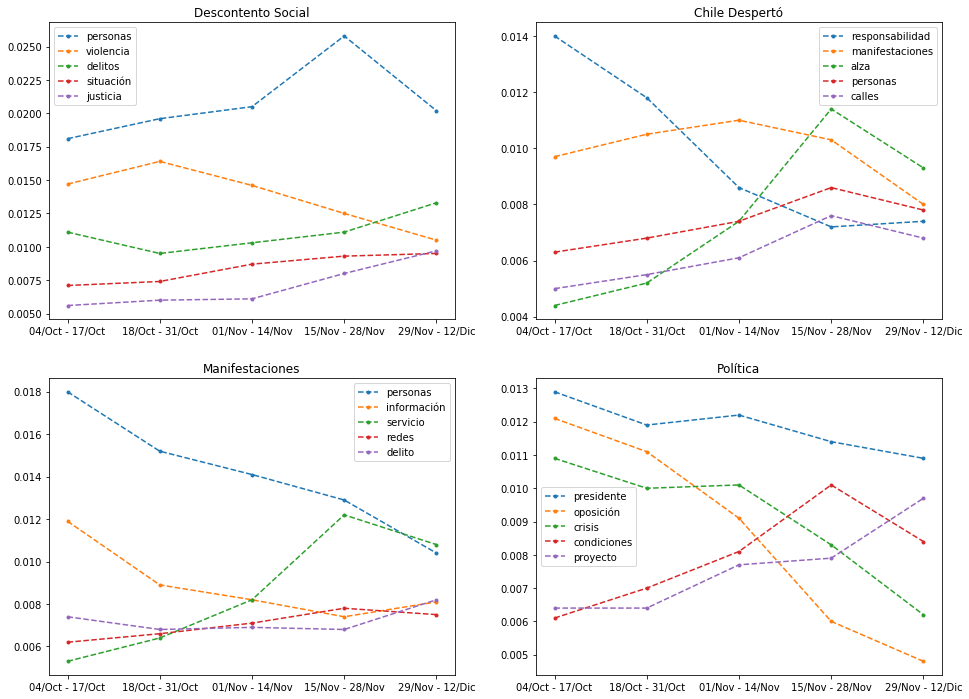

In [64]:
fig, ax = plt.subplots(2,2, figsize=(8*2, 6*2))
topics=range(true_k)
keywords=range(5)
xvalues=["04/Oct - 17/Oct","18/Oct - 31/Oct", "01/Nov - 14/Nov", "15/Nov - 28/Nov", "29/Nov - 12/Dic"]
titulos = ["Descontento Social","Chile Despertó","Manifestaciones","Política"]
k=0
for i in [0,1]:
    for j in [0,1]:
        # por cada AX(topics) tengo 5 lineas (kwds)
        kw_val = top_keywords[k][1]
        for w in keywords:
            Y = kw_val[w][1]
            kw = kw_val[w][0]
            ax[i][j].plot(xvalues,Y,'.--',label=kw)
            ax[i][j].set_title(titulos[k])
            ax[i][j].legend()
        k+=1
plt.show()

**Ejercicio 2:**
1. Repita el ejercicio con 6 tópicos y compare sus resultados.


In [65]:
true_k = 6
path_of_model = datapath("/run/media/amorales/392cf315-7e84-4743-a143-b375a0604f7d/amorales/UACh/magister/INFO343/Unidad4/INFO343/Unidad4/models/model_"+str(true_k)+"_clase")
ldaseq = LdaSeqModel.load(path_of_model)

In [66]:
table=[]
for topic in range(true_k):
    for i in range(len(index_slices)):
        row=["topic "+str(topic)]
        row.append("slice "+str(i))
        keywords=ldaseq.print_topic(topic=topic,time=i,top_terms=35)
        for keyword in keywords:
            row.append(str(keyword[0])+", "+str(round(keyword[1],4)))
        table.append(row)

In [67]:
topics_df = pd.DataFrame(table)
topics_df[:]

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,topic 0,slice 0,"seguridad, 0.0204","personas, 0.0198","orden, 0.0151","proyecto, 0.0149","servicios, 0.0137","responsabilidad, 0.0114","ley, 0.0111","casos, 0.0105",...,"tipo, 0.0066","empresas, 0.0064","manifestaciones, 0.0064","balines, 0.0063","medida, 0.0061","objetivo, 0.006","abogado, 0.0059","fuerza, 0.0057","aprobación, 0.0056","apoyo, 0.0055"
1,topic 0,slice 1,"personas, 0.0188","seguridad, 0.018","orden, 0.015","proyecto, 0.0136","servicios, 0.0129","ley, 0.0117","perdigones, 0.0113","responsabilidad, 0.011",...,"derechos, 0.0066","medida, 0.0063","fuerzas, 0.0062","tipo, 0.0061","recinto, 0.0061","fuerza, 0.0058","suspensión, 0.0057","elementos, 0.0057","apoyo, 0.0056","decreto, 0.0055"
2,topic 0,slice 2,"personas, 0.0215","seguridad, 0.0164","proyecto, 0.0149","ley, 0.0142","orden, 0.0134","funcionarios, 0.0116","servicios, 0.0113","perdigones, 0.0108",...,"fuerzas, 0.0065","abogado, 0.0065","nivel, 0.0063","apoyo, 0.0063","tipo, 0.0062","plan, 0.0062","fuerza, 0.006","medida, 0.0059","clases, 0.0057","decreto, 0.0057"
3,topic 0,slice 3,"personas, 0.0209","ley, 0.0153","proyecto, 0.015","seguridad, 0.014","militares, 0.0122","funcionarios, 0.0122","control, 0.0118","emergencia, 0.0116",...,"fuerzas, 0.0065","manifestaciones, 0.0065","recinto, 0.0064","plan, 0.0064","gobierno, 0.0063","clases, 0.0061","fuerza, 0.0061","suspensión, 0.0061","capital, 0.0058","decreto, 0.0058"
4,topic 0,slice 4,"personas, 0.018","proyecto, 0.0178","ley, 0.0162","control, 0.0126","servicios, 0.0115","seguridad, 0.0114","emergencia, 0.0108","funcionarios, 0.01",...,"acciones, 0.0064","clases, 0.0063","recinto, 0.0061","balines, 0.0059","fuerzas, 0.0058","jefa, 0.0058","manifestaciones, 0.0057","comunas, 0.0057","tipo, 0.0057","iniciativa, 0.0056"
5,topic 1,slice 0,"años, 0.0175","delito, 0.016","joven, 0.0154","investigación, 0.0134","hechos, 0.0133","delitos, 0.0124","comuna, 0.0119","antecedentes, 0.0106",...,"año, 0.006","manifestaciones, 0.0059","personal, 0.0059","hombre, 0.0058","martes, 0.0057","incendios, 0.0054","calle, 0.0053","fiscal, 0.0053","edad, 0.0052","especies, 0.0052"
6,topic 1,slice 1,"años, 0.0184","joven, 0.0168","delito, 0.0146","comuna, 0.0134","investigación, 0.0123","antecedentes, 0.0119","hechos, 0.0109","delitos, 0.0106",...,"manifestaciones, 0.0061","martes, 0.006","meses, 0.006","hombre, 0.0059","calle, 0.0059","edad, 0.0057","vehículos, 0.0056","año, 0.0055","fiscal, 0.0055","policía, 0.0053"
7,topic 1,slice 2,"años, 0.015","joven, 0.015","comuna, 0.0147","delito, 0.0144","antecedentes, 0.0133","investigación, 0.012","delitos, 0.0119","hechos, 0.0115",...,"hombre, 0.0062","prisión, 0.0062","madrugada, 0.006","gravedad, 0.006","calle, 0.0059","autoridad, 0.0059","policía, 0.0057","vehículos, 0.0056","homicidio, 0.0054","meses, 0.0054"
8,topic 1,slice 3,"comuna, 0.0171","antecedentes, 0.017","años, 0.0157","delito, 0.0138","investigación, 0.0125","delitos, 0.0121","joven, 0.0121","hechos, 0.0101",...,"policía, 0.0063","caso, 0.0063","ataque, 0.006","muerte, 0.006","homicidio, 0.0059","edad, 0.0058","niños, 0.0055","prisión, 0.0055","gravedad, 0.0054","meses, 0.0054"
9,topic 1,slice 4,"antecedentes, 0.0173","investigación, 0.017","delito, 0.016","años, 0.0152","delitos, 0.0135","comuna, 0.0134","joven, 0.0113","familia, 0.01",...,"grupo, 0.0061","meses, 0.006","martes, 0.0059","personas, 0.0059","víctimas, 0.0059","niños, 0.0058","ataque, 0.0058","mujer, 0.0057","edad, 0.0056","especies, 0.0055"


In [72]:
top_keywords = list()
for topic in range(true_k):
    print("\n#######################################")
    print("Topic = ", topic)
    kws_by_topic = list()
    keywords = []
    for i in range(5):
        col = 2
        values = []
        kw = table[topic*5+i][col].split(', ')[0]
        while((kw in useless) or (kw in keywords)):
            col+=1
            kw = table[topic*5+i][col].split(', ')[0]
        keywords.append(kw)
        print("\n····················")
        print("kw[",i,"] = ", kw)
        for slc in range(5):
            # el valor de la palabra encontrada en cada slice
            print("\n-------------------------------------")
            print("Slice = ", slc)
            col=2
            kw_ = table[topic*5+slc][col].split(', ')[0]
            while((kw_ != kw) and col<36):
                print(kw_,"no calza con", kw, "  col =",col)
                col+=1
                kw_ = table[topic*5+slc][col].split(', ')[0]
            if col<36:
                sc = float(table[topic*5+slc][col].split(', ')[1])
                print("\n", kw_,"si calza con",kw,)
            else:
                print("palabra",kw,"no encontrada en slice",slc)
                sc = 0
            values.append(sc)
            print("Valores = ",values,"\n")
            
        kws_by_topic.append([kw,values])
    
    top_keywords.append([topic,kws_by_topic])


#######################################
Topic =  0

····················
kw[ 0 ] =  seguridad

-------------------------------------
Slice =  0

 seguridad si calza con seguridad
Valores =  [0.0204] 


-------------------------------------
Slice =  1
personas no calza con seguridad   col = 2

 seguridad si calza con seguridad
Valores =  [0.0204, 0.018] 


-------------------------------------
Slice =  2
personas no calza con seguridad   col = 2

 seguridad si calza con seguridad
Valores =  [0.0204, 0.018, 0.0164] 


-------------------------------------
Slice =  3
personas no calza con seguridad   col = 2
ley no calza con seguridad   col = 3
proyecto no calza con seguridad   col = 4

 seguridad si calza con seguridad
Valores =  [0.0204, 0.018, 0.0164, 0.014] 


-------------------------------------
Slice =  4
personas no calza con seguridad   col = 2
proyecto no calza con seguridad   col = 3
ley no calza con seguridad   col = 4
control no calza con seguridad   col = 5
servicios no cal

país no calza con derecho   col = 3
decisión no calza con derecho   col = 4

 derecho si calza con derecho
Valores =  [0.0103, 0.0111, 0.0113, 0.0129] 


-------------------------------------
Slice =  4
personas no calza con derecho   col = 2
país no calza con derecho   col = 3

 derecho si calza con derecho
Valores =  [0.0103, 0.0111, 0.0113, 0.0129, 0.0132] 


····················
kw[ 2 ] =  decisión

-------------------------------------
Slice =  0
personas no calza con decisión   col = 2
país no calza con decisión   col = 3
información no calza con decisión   col = 4

 decisión si calza con decisión
Valores =  [0.0104] 


-------------------------------------
Slice =  1
personas no calza con decisión   col = 2
país no calza con decisión   col = 3
derecho no calza con decisión   col = 4

 decisión si calza con decisión
Valores =  [0.0104, 0.011] 


-------------------------------------
Slice =  2
personas no calza con decisión   col = 2
país no calza con decisión   col = 3

 decisió

In [73]:
top_keywords

[[0,
  [['seguridad', [0.0204, 0.018, 0.0164, 0.014, 0.0114]],
   ['personas', [0.0198, 0.0188, 0.0215, 0.0209, 0.018]],
   ['proyecto', [0.0149, 0.0136, 0.0149, 0.015, 0.0178]],
   ['ley', [0.0111, 0.0117, 0.0142, 0.0153, 0.0162]],
   ['control', [0.0077, 0.0086, 0.0091, 0.0118, 0.0126]]]],
 [1,
  [['delito', [0.016, 0.0146, 0.0144, 0.0138, 0.016]],
   ['investigación', [0.0134, 0.0123, 0.012, 0.0125, 0.017]],
   ['antecedentes', [0.0106, 0.0119, 0.0133, 0.017, 0.0173]],
   ['delitos', [0.0124, 0.0106, 0.0119, 0.0121, 0.0135]],
   ['víctima', [0.0082, 0.0091, 0.01, 0.0099, 0.0099]]]],
 [2,
  [['estallido', [0.0186, 0.0133, 0.011, 0.007, 0.0062]],
   ['manifestaciones', [0.0158, 0.0162, 0.0144, 0.0118, 0.0097]],
   ['estaciones', [0.0117, 0.0133, 0.015, 0.0177, 0.0155]],
   ['alza', [0.0085, 0.01, 0.0133, 0.0178, 0.0144]],
   ['protestas', [0.0106, 0.0124, 0.0146, 0.0153, 0.0127]]]],
 [3,
  [['personas', [0.0333, 0.0335, 0.0353, 0.0437, 0.035]],
   ['derecho', [0.0103, 0.0111, 0.0113, 

####  Dar un nombre a los 6 tópicos:

**Palabras Clave:**
- Tópico 0: "Seguridad-Personas-Proyecto-Ley-Control" 
- Tópico 1: "Delito-Investigación-Antecedentes-Delitos-Víctima"
- Tópico 2: "Estallido-Manifestaciones-Estaciones-Alza-Protestas"
- Tópico 3: "Personas-Derecho-Decisión-Autoridades-Recursos"
- Tópico 4: "Violaciones-Violencia-Medidas-Crisis-Presidente"
- Tópico 5: "Oposición-Presidente-Ministro-Palabras-Salud"

**Nombres:**
- Topico 0 = "Orden Público"
- Topico 1 = "Incidentes"
- Topico 2 = "Manifestaciones y Descontento"
- Tópìco 3 = "Política"
- Tópico 4 = "Crisis Social"
- Tópico 5 = "Respuestas del Gobierno"

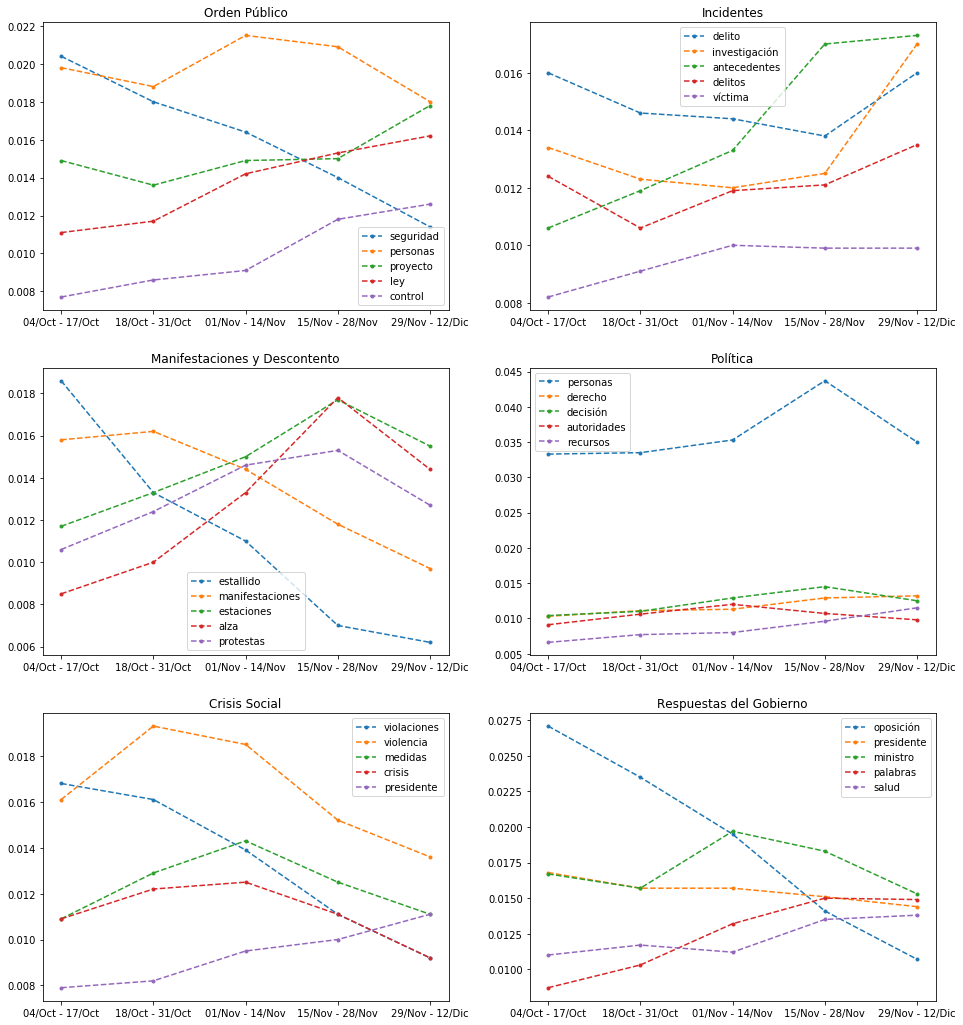

In [74]:
fig, ax = plt.subplots(3,2, figsize=(8*2, 6*3))
topics=range(true_k)
keywords=range(5)
xvalues=["04/Oct - 17/Oct","18/Oct - 31/Oct", "01/Nov - 14/Nov", "15/Nov - 28/Nov", "29/Nov - 12/Dic"]
titulos = ["Orden Público","Incidentes","Manifestaciones y Descontento","Política","Crisis Social","Respuestas del Gobierno"]
k=0
for i in [0,1,2]:
    for j in [0,1]:
        # por cada AX(topics) tengo 5 lineas (kwds)
        kw_val = top_keywords[k][1]
        for w in keywords:
            Y = kw_val[w][1]
            kw = kw_val[w][0]
            ax[i][j].plot(xvalues,Y,'.--',label=kw)
            ax[i][j].set_title(titulos[k])
            ax[i][j].legend()
        k+=1
plt.show()

> Vemos que con $k=6$ tópicos, existe mayor covertura temática, las palabras son más variadas entre tópicos, a diferencia con $k=4$ tópicos donde eran más similares entre sí. Notamos también que existen palabras claves que aparecen en el primer caso, con $k=4$ tópicos, pero que posteriormente no están presentes, como por ejemplo: 'personas', 'justicia' y 'calles'.

> Se observan claras tendencias temporales tempranas (segunda y tercera slices) de que existió mayor mención a palabras referentes a las manifestaciones en sí, tales como: 'crisis', 'violencia', 'protestas','calles' y 'alza'.

> Del mismo modo, existieron notables tendencias tardías (cuarta y quinta slices) que tuvieron que ver más con reacciones hacia las manifestaciones, donde encontramos palabras como: 'víctima', 'medidas', 'proyecto', 'ley' y 'presidente'.


**Ejercicio 3:**

1. ¿Cuáles son las limitaciones del protocolo utilizado? ¿Qué se podría mejorar?

> Las limitaciones para el análisis yacen en la elección de los algoritmos y las medidas de coherencia. Para mejorar la metodología se podrían considerar más pruebas o criterios de decisión para la elección de cantidad de tópicos y/o de palabras claves.

2. A partir de este conjunto de noticias ¿Cómo interpreta lo que pasó entre el 4 de octubre y 13 de diciembre? ¿Cómo se podría continuar el análisis para obtener conclusiones más precisas?

> Observando de manera abstracta, es decir, como alguien que por alguna razón no estuvo en el país en esas fechas y/o extranjera, se puede decir que entre Octubre y Diciembre de 2019 fue un período marcado por conflictos sociales, en particular entre la segunda y tercera slice, es decir, fines de octubre hasta noviembre.

> Para un análisis más profundo con conclusiones precisas, habría que analizar mayor cantidad de noticias que a su vez provengan de distintos medios, ya que en este caso sólo se contaba con un dataset de un único medio.